### Time Series Workshop 
# 5. Online Retail &#x1F4B0;: Forecasting Challenge

Eh, this is a sample solution for the previous challenge. 

You were'nt supposed to see this. Ah, whatever. &#x1F937;

In [1]:
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from feature_engine.creation import CyclicalFeatures
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer as ftrf

from timeseries.data import load_retail
from timeseries.utils import print_metrics
from timeseries import preprocessing as pp

DATA_DIR = Path("..") / Path("data")

## Load data

In [2]:
TARGET_COL = "sales"
SPLIT_DATE = "2011-09-30"
FILE_PATH = DATA_DIR / "online_retail.csv"

df_in = load_retail(FILE_PATH)
df_in.head()

,sales
month,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


## Analyze data
- Make yourselves familiar with the data. This one doesn't have too many pitfalls.. hopefully.
- Do we have missing data?
- Can we see some obvious seasonal pattern? If so, what could be the reason for this?

<Axes: xlabel='month'>

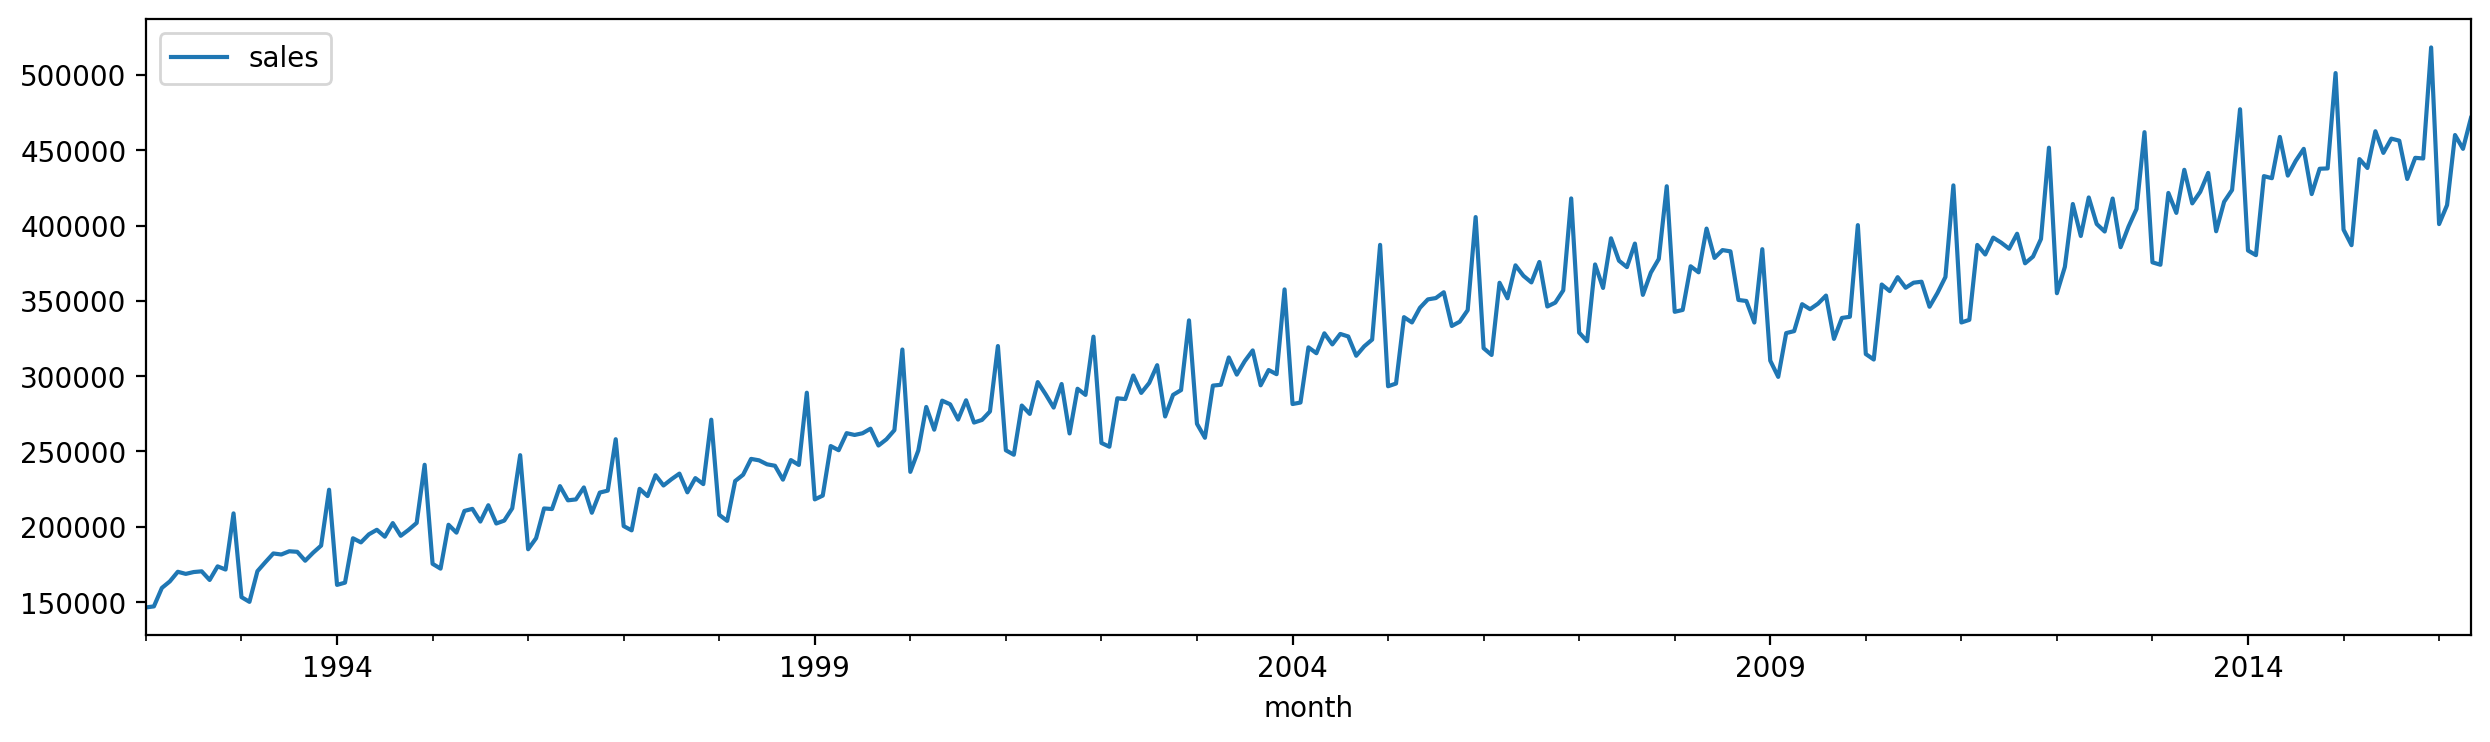

In [4]:
df = df_in.copy()

_ = df.plot(figsize=[15, 4])

## Feature engineering
- Create some features that you think might be useful for forecasting
- Do we need to do some more pre-processing?

In [20]:
...

Ellipsis

## Train-test split
- Split the data into train- and test sets according to the SPLIT_DATE parameter defined above


In [21]:
...

Ellipsis

## Build models and forecast!
- Fit the processed training data 
- Predict for the test set
- Calculate the usual metrics
  - How good is your forecast? Compare a naive baseline model with something more sophisticated.
  - What metric is the most appropriate here?
  - Can you manage to beat my own forecast? (We will have a little competition here) &#x1F6A8;

Good luck!

In [22]:
...

Ellipsis